In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import random_rotation, random_shift, random_shear, random_zoom, random_channel_shift
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.optimizers.experimental import SGD

import sys, os, h5py, re, datetime, random, copy, glob, fnmatch
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from cv2 import erode, dilate
from scipy import stats

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean, rotate, AffineTransform, warp
from skimage.io import imread, imsave

import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

import PIL.Image
import PIL.ImageEnhance
import PIL.ImageOps 

from models import iunet
from helpers import *

2023-11-20 17:53:04.308942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 17:53:08.544429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 17:53:09.436122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15389 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0d:00.0, compute capability: 6.0


In [2]:
J_ROOT = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
input_dir = os.path.join(J_ROOT, 'data/pecot_dice', 'annotated_datasets', '23-09-15_Annotation', 'annotation')
crop_dir_base = os.path.join(J_ROOT, 'data/pecot_dice', 'annotated_datasets', '23-09-15_Annotation', '23-11-20_48x48s_cNp_ErDi_nNorm')
crop_dir = os.path.join(crop_dir_base, 'cNp')
conv_dir = os.path.join(crop_dir_base, 'conv')
output_dir = os.path.join(crop_dir_base, 'npz')

for dir in [crop_dir, conv_dir, output_dir]:
    os.makedirs(dir, exist_ok = True)
#parameters = [input_dir, output_dir, nb_classes, window_size_x, window_size_y, normalization]

In [3]:
nb_classes = 3
window_size_x = 48
window_size_y = 48
normalization = 'none'

In [4]:
# search images to find smallest dimension
smallest = get_largest_dim(getfiles(input_dir))
image_size_x, image_size_y = smallest, smallest
print(f"The largest image dimension is {smallest}.\n" \
      + f"All images will be randomly cropped and resized to {smallest}x{smallest}.\n" \
      + f"Prediction outputs will be the same size, but will be cropped back to original.")

The largest image dimension is 1076.
All images will be randomly cropped and resized to 1076x1076.
Prediction outputs will be the same size, but will be cropped back to original.


In [5]:
def get_boxes(NUM_CROPS, BATCH_SIZE):
    boxes1 = tf.random.uniform(shape = (NUM_CROPS, 2), minval = 0.0, maxval = 0.8)
    boxes2 = boxes1 + tf.random.uniform(shape = (NUM_CROPS, 2), minval = 0.2, maxval = 1)
    boxes = tf.concat([boxes1, boxes2], axis = 1)
    indices = tf.where(tf.math.greater(boxes, 1))
    boxes = tf.tensor_scatter_nd_update(boxes, indices, tf.ones(shape=indices.shape[0]))
    box_indices = tf.random.uniform(shape = (NUM_CROPS, ), minval = 0, maxval = BATCH_SIZE, dtype = tf.int32)
    return boxes, box_indices

In [6]:
%%capture
#generate crops
image_directories = [i for i in os.listdir(input_dir)]

ncrops = 23
# bases should always include 'base'. Can include 'ero' for erode and 'dil' for dilate.
mods = ['none', 'ero', 'dil']
nimgs = 0

crop_list = []
for directory in image_directories:
    BOXES, INDICES = get_boxes(ncrops, 1)
    crop_mods = {}
    basedir = os.path.join(crop_dir, f"{directory}")
    os.makedirs(basedir, exist_ok = True)
    
    for image in os.listdir(os.path.join(input_dir, directory)):
        if image == '.ipynb_checkpoints' or image == "Thumbs.db" or image == ".DS_Store":
            continue

        im = get_image(os.path.join(input_dir, directory, image))
        if im.max() != 255.0 or im.dtype != np.float32:
            im = to8bit(im)
            assert im.max() == 255.0
            #temp = np.zeros(im.shape, dtype=np.uint8)
            #tim = im.astype('float32') / get_tinfo(im).max
            #tim *= get_tinfo(temp).max
            #temp[:,:] = tim[:,:]
            #im = temp

        assert len(im[im != 0]) != 0
        assert len(im[~np.isfinite(im)]) == 0
   
        padded = get_padded(im, image_size_x, image_size_y)
        
        crop_list.append(padded)
        imsave(os.path.join(basedir, image), padded)
        im_crops = tf.image.crop_and_resize(padded[None,:,:,None], BOXES, INDICES, 
                                            (image_size_x, image_size_y))
        nimgs += 1        
        im_crops = im_crops.numpy()

        for cdx, crop in enumerate(im_crops):
            if cdx not in crop_mods.keys():
                # choose between possible modifications (such as erosion or dilation)
                cc = random.choice(mods)
                # randomize modification kernel
                cd = random.randint(3, 6)
                erdi_kernel = np.ones((cd, cd), np.uint8)
                crop_mods[cdx] = (cc, erdi_kernel)
            else:
                cc, erdi_kernel = crop_mods[cdx]
                       
            os.makedirs(os.path.join(crop_dir, f"{directory}_c{cdx}"), exist_ok=True)
            savepath = os.path.join(crop_dir, f"{directory}_c{cdx}", image)

            if cc == 'ero':
                if image == 'feature_2.tif':
                    crop[:,:,0] = dilate(crop[:,:,0], erdi_kernel, iterations=1)
                else:
                    crop[:,:,0] = erode(crop[:,:,0], erdi_kernel, iterations=1)
            elif cc == 'dil':
                if image == 'feature_2.tif':
                    crop[:,:,0] = erode(crop[:,:,0], erdi_kernel, iterations=1)
                else:
                    crop[:,:,0] = dilate(crop[:,:,0], erdi_kernel, iterations=1)
            elif cc == 'none':
                pass
            else:
                raise ValueError(f"Modification {cc} not recognized. Please choose from 'ero', 'dil', or 'none'")
                
            nimgs += 1
            imsave(savepath, crop[:,:,0].astype('float32'))

2023-11-20 17:53:10.871406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15389 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0d:00.0, compute capability: 6.0


144
Plotting 576 out of 576...
Rendering...


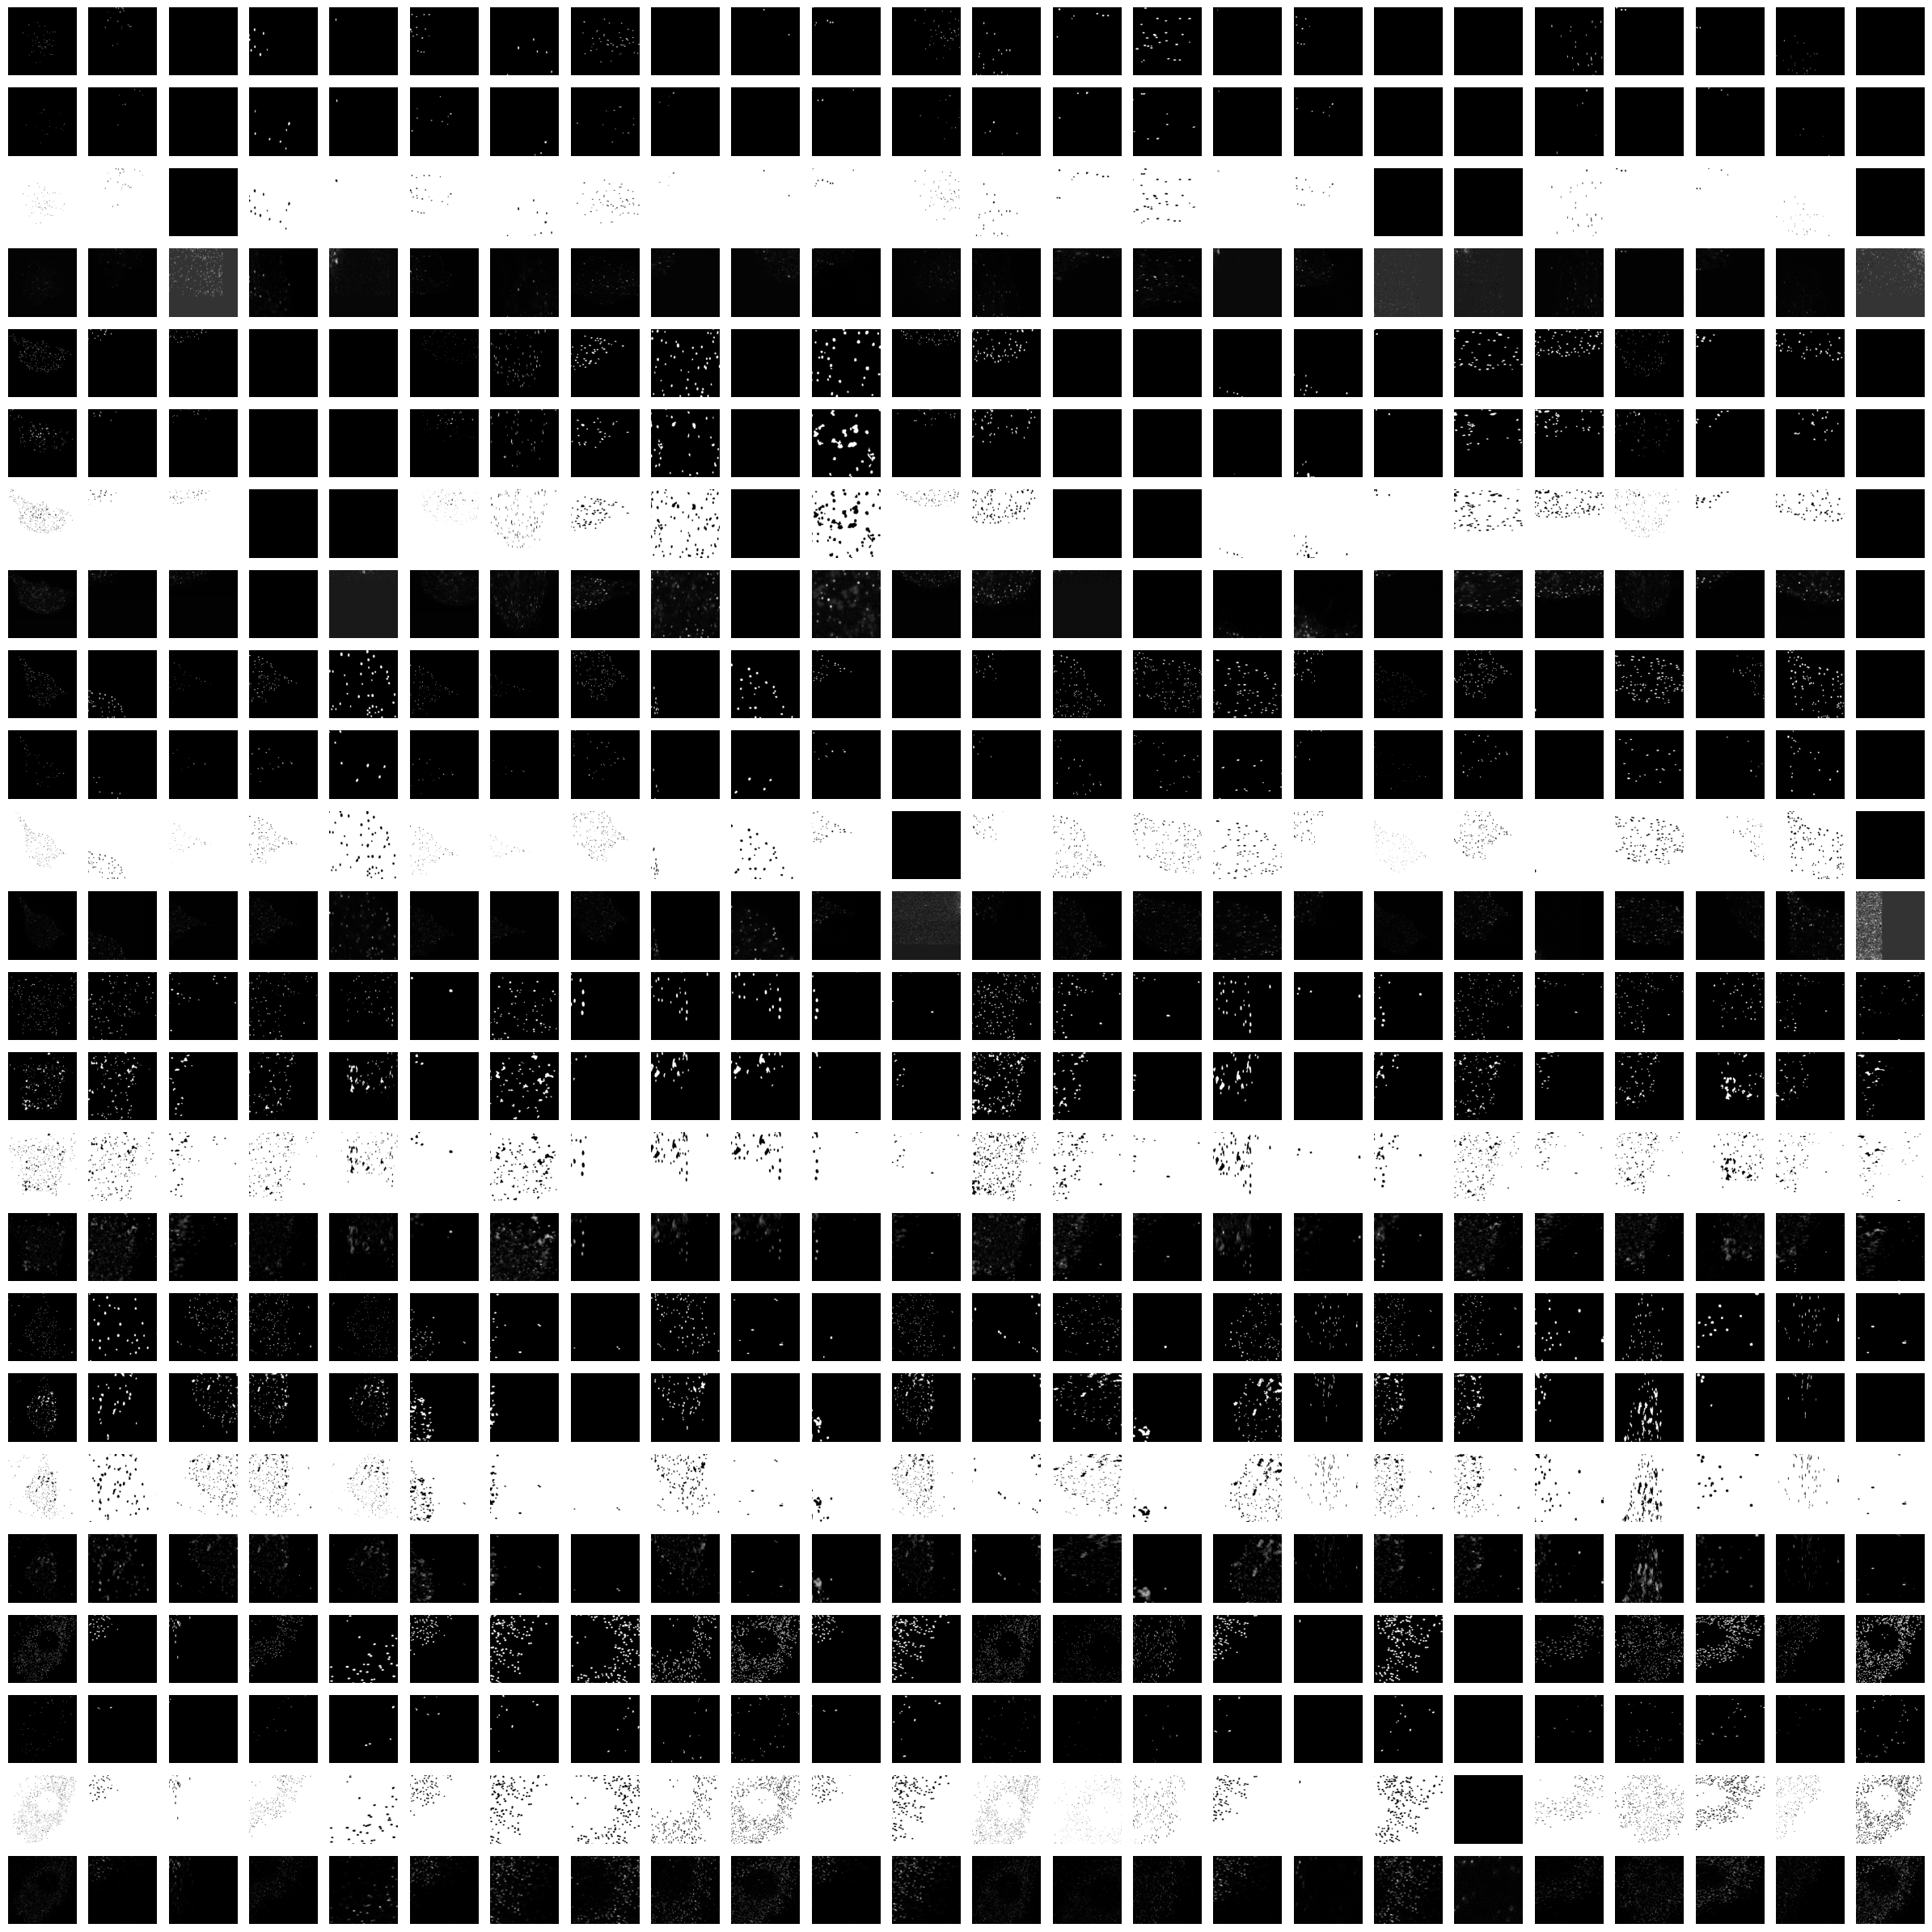

In [7]:
cols = (ncrops + 1)
rows = int(np.ceil(nimgs / cols))

fig = plt.figure(figsize=(cols, rows))
loopdirs = sorted_nicely(os.listdir(crop_dir))
print(len(loopdirs))
count = 0

for cdx, x in enumerate(loopdirs):
    floopimgs = sorted_nicely(os.listdir(os.path.join(crop_dir, x)))
    for fdx, f in enumerate(floopimgs):
        print(f"\rPlotting {cdx * len(floopimgs) + fdx + 1} out of {cols * rows}...", end = '')
        ax = fig.add_subplot(rows, cols, int((np.floor(cdx / cols) * 4 * cols) + np.mod(cdx, cols) + (fdx * cols) + 1))
        im = imread(os.path.join(crop_dir, x, f))
        ax.imshow(im, cmap = "gray")
        ax.axis('off')
        count += 1
print("\nRendering...")
plt.tight_layout()

In [8]:
direc_name = crop_dir
file_name_save = os.path.join(output_dir, 'data.npz')
training_direcs = [i for i in os.listdir(direc_name)]
channel_names = ["image"]

# maximum number of training cases
max_training_examples = 10000000

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += getfiles(direc)

In [9]:
ch_masks = np.zeros((len(training_direcs), image_size_x, image_size_y, nb_channels + nb_classes), dtype='float32')

In [10]:
direc_counter = 0
for ddx, direc in enumerate(training_direcs):
    imglist = os.listdir(os.path.join(direc_name, direc))
    imgdir = os.path.join(conv_dir, direc)
    if not os.path.isdir(imgdir):
        os.mkdir(imgdir)

    print(f"\rLoading Image {ddx + 1}/{len(training_direcs)}", end = "")
    
    for idx, img in enumerate(imglist):
        imgpath = os.path.join(direc_name, direc, img)
        if img == 'image.tif':
            ch_masks[ddx, :, :, 0] = get_image(imgpath)
        else:
            fidx = int(img.split('.')[0].split('_')[1]) + 1
            ch_masks[ddx, :, :, fidx] = get_image(imgpath)

Loading Image 144/144

In [11]:
ch_masks_norm = ch_masks
assert ch_masks_norm.max() == 255.0

In [12]:
if normalization == 'nuclei segmentation':
    kernel = np.ones((window_size_x, window_size_y, nb_channels, nb_channels), dtype = 'float32')
    kernel_tf = tf.constant(kernel)
    convolved = np.zeros((len(training_direcs), image_size_x, image_size_y, nb_channels), dtype = 'float32')
    
    for cdx in np.arange(1, 49):
        print(f"\rConvolving batch {cdx}/48", end='')
    
        #definitions
        bigx, bigy = image_size_x + window_size_x, image_size_y + window_size_y
        xstep, ystep = int(window_size_x / 2), int(window_size_y / 2)
        these_masks = ch_masks[((cdx - 1) * 3) : (cdx * 3), :, :, :nb_channels]
    
        #creating canvas and filling with images
        canvas = np.full((3, bigx, bigy, nb_channels), np.mean(these_masks), dtype = 'float32')
        canvas[:, xstep : image_size_x + xstep, ystep : image_size_y + ystep, :] = these_masks
    
        #performing convolution and splicing result
        conv = tf.nn.conv2d(tf.constant(canvas), kernel_tf, [1, 1, 1, 1], 'SAME')
        convolved[((cdx - 1) * 3) : (cdx * 3), :, :, :] = conv[:, xstep : image_size_x + xstep, ystep : image_size_y + ystep, :]
    
    convolved = convolved / (window_size_x * window_size_y)
    ch_masks_norm[:,:,:,:nb_channels] = ch_masks[:,:,:,:nb_channels] - convolved

In [13]:
ch_masks_norm[:,:,:,nb_channels:] /= ch_masks_norm[:,:,:,nb_channels:].max()

In [14]:
ch_masks_norm[:,:,:,nb_channels:][ch_masks_norm[:,:,:,nb_channels:] >= 0.5] = 1.0
ch_masks_norm[:,:,:,nb_channels:][ch_masks_norm[:,:,:,nb_channels:] < 0.5] = 0.0

Plotting 576 out of 576...
Rendering...


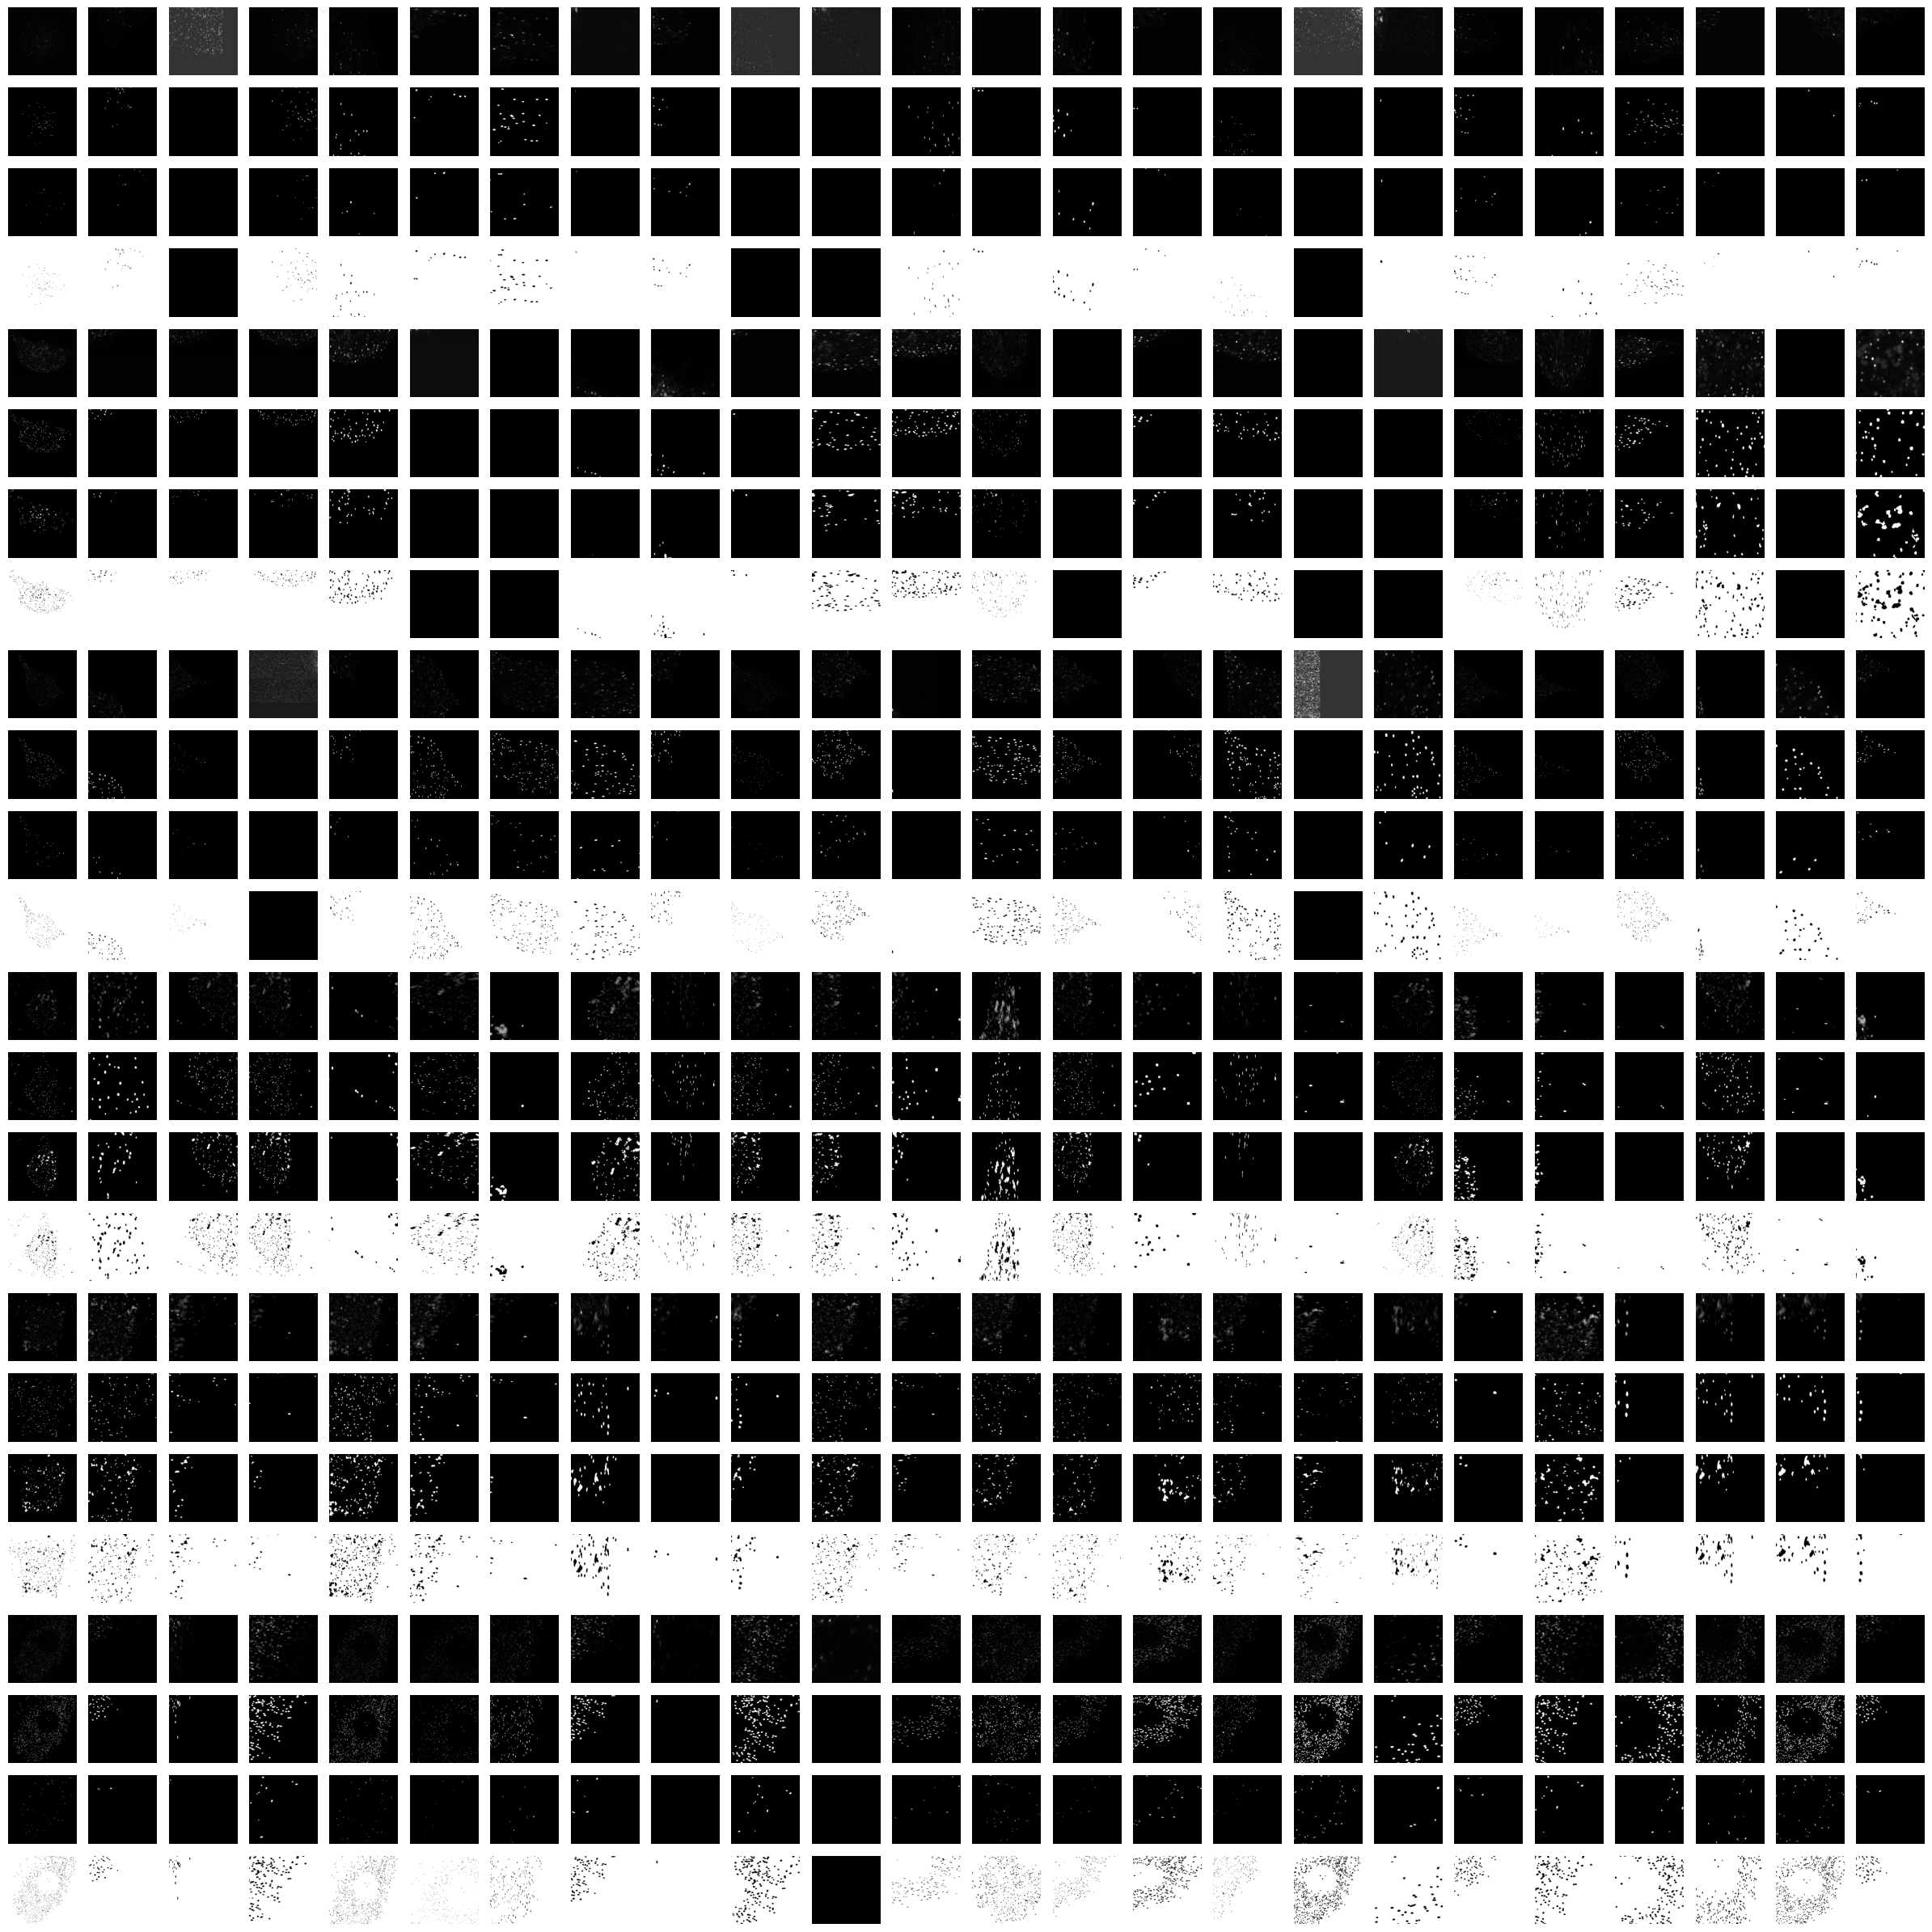

In [15]:
cols = int(ncrops + 1)
rows = int(np.ceil(nimgs / cols))

fig = plt.figure(figsize=(cols, rows))
count = 0

for idx, img in enumerate(ch_masks_norm):
    for fidx in range(ch_masks_norm.shape[-1]):
        print(f"\rPlotting {idx * ch_masks_norm.shape[-1] + fidx + 1} out of {cols * rows}...", end = '')
        img_index = int((np.floor(idx / cols) * 4 * cols) + (np.mod(idx, cols) + (fidx * cols) + 1))
        ax = fig.add_subplot(rows, cols, img_index)
        ax.imshow(img[:,:,fidx], cmap='gray')
        ax.axis('off')
        count += 1
print("\nRendering...")
plt.tight_layout()

In [16]:
# Initialize arrays for the training images and the classes
channels = ch_masks_norm[:,:,:,:nb_channels]
class_mask = ch_masks_norm[:,:,:,nb_channels:]

In [17]:
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class
            
for direc in range(channels.shape[0]):
    
    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

np.savez(file_name_save, 
         channels = channels, y_all = class_mask,
         central_y = class_label, batch = class_batch, 
         pixels_x = class_rows, pixels_y = class_cols, 
         win_x = window_size_x, win_y = window_size_y)